# Automatic Gaussian Mixture Modeling

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set(font_scale=1.75)
sns.set_style("white")

import random
np.random.seed(10)

Clustering is a foundational data analysis task, where members of the data set are sorted into groups or "clusters" according to measured similarities between the objects.

The Automatic Gaussian Mixture Model (AutoGMM) is a clustering algorithm that uses Sklearn's hierarchical agglomerative clustering and then Gaussian mixtured model (GMM) fitting. Different combinations of agglomeration, GMM, and cluster numbers are used in the algorithm, and the clustering with the best selection criterion, either Bayesian information criterion (bic) or Akaike information criterion (aic), is chosen.

The Gaussian mixture model (GMM) is a statistical model of clustered data that, simply put, is a composition of multiple normal distributions. Each cluster has a weight $w_k$ assigned to it, and the combined probability distribution, $f(x)$, is of the form:

$$f(x) = \sum\limits_{k = 1}^K {w_{k}f_{k}(x)} = \sum\limits_{k = 1}^K {\frac{w_{k}}{(2\pi)^{\frac{d}{2}}\big|\sum_{k}\big|^{-\frac{1}{2}}}e^{\frac{1}{2}(x - \mu_{k})^{T}\sum_{k}^{-1}(x - \mu_{k})}}$$

where $k$ is the total number of clusters and $d$ is the dimensionality of the data.

Expectation Maximization (EM) algorithms are then run to estimate model parameters and the fitted GMM is used to cluster the data.

## Using AutoGMM on Synthetic Data

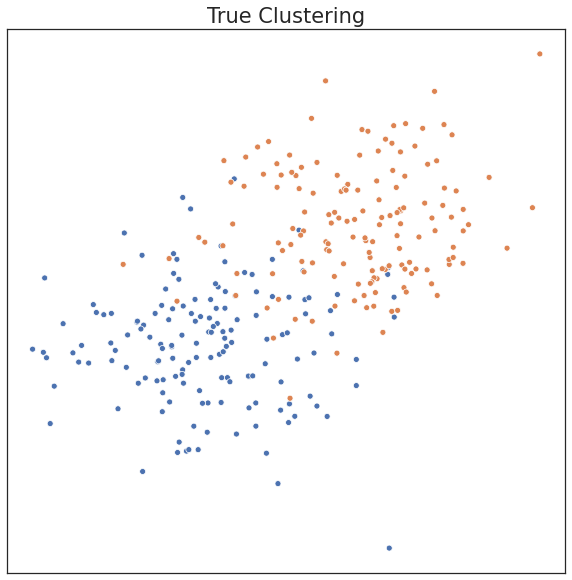

In [2]:
# Synthetic data

# Dim 1
class_1 = np.random.randn(150, 1)
class_2 = 2 + np.random.randn(150, 1)
dim_1 = np.vstack((class_1, class_2))

# Dim 2
class_1 = np.random.randn(150, 1)
class_2 = 2 + np.random.randn(150, 1)
dim_2 = np.vstack((class_1, class_2))

X = np.hstack((dim_1, dim_2))

# Labels
label_1 = np.zeros((150, 1))
label_2 = 1 + label_1

c = np.vstack((label_1, label_2)).reshape(300,)

# Plotting Function for Clustering
def plot(title, c_hat, X):
    plt.figure(figsize=(10, 10))
    n_components = int(np.max(c_hat) + 1)
    palette = sns.color_palette("deep")[:n_components]
    fig = sns.scatterplot(x=X[:,0], y=X[:,1], hue=c_hat, legend=None, palette=palette)
    fig.set(xticks=[], yticks=[], title=title)
    plt.show()

plot('True Clustering', c, X)

In the existing implementation of GMM in Sklearn, one has to choose parameters of the model, including number of components, apriori. If parameters are input that don't match the data well, clustering performance can suffer. Performance can be measured by ARI, a metric ranging from 0 to 1. An ARI score of 1 indicates the estimated clusters are identical to the true clusters.

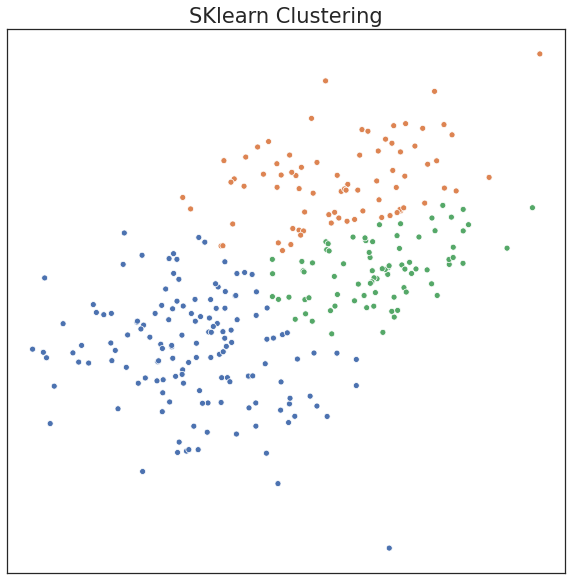

ARI Score for Model: 0.48


In [3]:
from sklearn import mixture
from sklearn.metrics import confusion_matrix
from scipy.optimize import linear_sum_assignment
from sklearn.metrics import adjusted_rand_score

# Say user provides inaccurate estimate of number of components
gmm_ = mixture.GaussianMixture(3)
c_hat_gmm = gmm_.fit_predict(X)

# Function to remap labels for direct comparison
def remap_labels(y_true, y_pred):

    confusion_mat = confusion_matrix(y_true, y_pred)
    row_inds, col_inds = linear_sum_assignment(confusion_mat, maximize=True)
    label_map = dict(zip(col_inds, row_inds))
    remapped_y_pred = np.vectorize(label_map.get)(y_pred)
    
    return remapped_y_pred

# Remap Predicted labels
c_hat_gmm = remap_labels(c, c_hat_gmm)

plot('SKlearn Clustering', c_hat_gmm, X)

# ARI Score
print("ARI Score for Model: %.2f" % adjusted_rand_score(c, c_hat_gmm))

Our method expands upon the existing Sklearn framework by allowing the user to automatically find the optimal parameters for a Gaussian mixture model and achieve the best clustering possible. In particular, the ideal `n_components_` is found by AutoGMM from a range of possible values given by the user. AutoGMM also finds the ideal covariance structure.

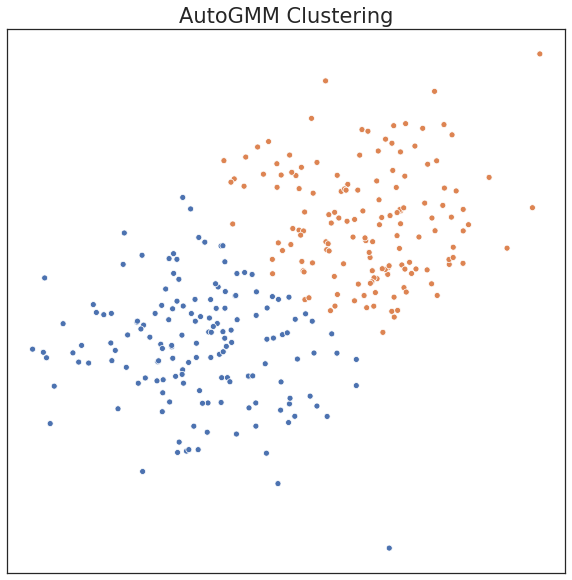

ARI Score for Model: 0.67


In [4]:
from graspologic.cluster.autogmm import AutoGMMCluster

# Fit AutoGMM model
autogmm_ = AutoGMMCluster(min_components=1, max_components=10)
c_hat_autogmm = autogmm_.fit_predict(X)

c_hat_autogmm = remap_labels(c, c_hat_autogmm)

plot('AutoGMM Clustering', c_hat_autogmm, X)

print("ARI Score for Model: %.2f" % adjusted_rand_score(c, c_hat_autogmm))